In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor
import optuna

CPU times: user 1.97 s, sys: 892 ms, total: 2.86 s
Wall time: 2.34 s


In [2]:
df = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
test["num_sold"] = 0

In [5]:
combined = pd.concat([df, test])

In [6]:
dep_var = "num_sold"

In [7]:
holiday = pd.read_csv("nordic_holidays.csv")

In [8]:
holiday.head()

,Unnamed: 0,date,holiday,country
0,0,2016-01-01,Uudenvuodenpäivä,Finland
1,1,2016-01-06,Loppiainen,Finland
2,2,2016-03-25,Pitkäperjantai,Finland
3,3,2016-03-27,Pääsiäispäivä,Finland
4,4,2016-03-28,2. pääsiäispäivä,Finland


In [9]:
holiday["holiday"] = str("in_") + holiday["country"]
display(holiday.head())

,Unnamed: 0,date,holiday,country
0,0,2016-01-01,in_Finland,Finland
1,1,2016-01-06,in_Finland,Finland
2,2,2016-03-25,in_Finland,Finland
3,3,2016-03-27,in_Finland,Finland
4,4,2016-03-28,in_Finland,Finland


In [10]:
combined = combined.merge(holiday[["date", "holiday", "country"]], left_on = ["date", "country"], right_on = ["date", "country"], how = "left")

In [11]:
combined["holiday"].value_counts(dropna = False)

NaN           31578
in_Sweden       480
in_Finland      450
in_Norway       360
Name: holiday, dtype: int64

In [12]:
combined["holiday"] = combined["holiday"].fillna("no_holiday")

In [13]:
country_map = pickle.load(open("embs/country_map.pkl", "rb"))
month_map = pickle.load(open("embs/month_map.pkl", "rb"))
product_map = pickle.load(open("embs/product_map.pkl", "rb"))
store_map = pickle.load(open("embs/store_map.pkl", "rb"))

In [14]:
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_country = pd.DataFrame(combined['country'].map(country_map).to_list(), columns = col_name)

emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_product = pd.DataFrame(combined['product'].map(product_map).to_list(), columns = col_name)

emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_store = pd.DataFrame(combined['store'].map(store_map).to_list(), columns = col_name)

In [15]:
combined.reset_index(drop = True, inplace = True)

In [16]:
combined = pd.concat([combined, df_emb_store, df_emb_product, df_emb_country], axis = 1)

In [17]:
combined[dep_var] = np.log(combined[dep_var])

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
combined = add_datepart(combined, 'date')

In [19]:
combined.head()

,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Finland,KaggleMart,Kaggle Mug,5.796058,in_Finland,0.967750,-0.929185,1.117330,-0.345529,...,1,3,1,False,True,False,True,False,True,1.420070e+09
1,1,Finland,KaggleMart,Kaggle Hat,6.253829,in_Finland,0.967750,-0.929185,1.117330,0.764051,...,1,3,1,False,True,False,True,False,True,1.420070e+09
2,2,Finland,KaggleMart,Kaggle Sticker,4.983607,in_Finland,0.967750,-0.929185,1.117330,-1.278340,...,1,3,1,False,True,False,True,False,True,1.420070e+09
3,3,Finland,KaggleRama,Kaggle Mug,6.349139,in_Finland,-0.300273,0.358641,-0.296122,-0.345529,...,1,3,1,False,True,False,True,False,True,1.420070e+09
4,4,Finland,KaggleRama,Kaggle Hat,6.814543,in_Finland,-0.300273,0.358641,-0.296122,0.764051,...,1,3,1,False,True,False,True,False,True,1.420070e+09


In [20]:
emb_dim = month_map[1].shape[0]
col_name = [f'month_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_month = pd.DataFrame(combined['Month'].map(month_map).to_list(), columns = col_name)

In [21]:
combined = pd.concat([combined, df_emb_month], axis = 1)

In [22]:
gdp = pd.read_csv("GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv")

gdp = gdp.melt(id_vars = 'year', value_vars = ['Finland', 'Norway', 'Sweden'], var_name = 'country', value_name = 'gdp')

In [23]:
combined = combined.rename(columns = {"Year" : "year"})

In [24]:
combined = combined.merge(gdp, on = ["country", "year"], how = "left")

In [71]:
train_idx = combined.iloc[0:26298].index
#valid_idx = combined.iloc[22986:26298].index
test_idx = combined.iloc[26298:].index

In [72]:
cont, cat = cont_cat_split(combined, 1, dep_var)

In [73]:
cont

['row_id',
 'store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Elapsed',
 'month_emb_1',
 'month_emb_2',
 'month_emb_3',
 'month_emb_4',
 'month_emb_5',
 'month_emb_6',
 'month_emb_7',
 'gdp']

In [74]:
cat

['country',
 'store',
 'product',
 'holiday',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [75]:
cont.remove("row_id")

In [30]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(valid_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [31]:
trainxs, trainy = to.train.xs, to.train.y
validxs, validy = to.valid.xs, to.valid.y

In [32]:
print (trainxs.shape, trainy.shape)
print (validxs.shape, validy.shape)

(26298, 34) (26298,)
(3312, 34) (3312,)


In [33]:
validy

22986    5.424950
22987    6.248043
22988    4.927254
22989    5.993961
22990    6.711740
           ...   
26293    6.712956
26294    5.521461
26295    6.911747
26296    7.273093
26297    5.961005
Name: num_sold, Length: 3312, dtype: float64

In [34]:
def SMAPE(preds, targs):
    denominator = (targs + np.abs(preds)) / 200.0
    diff = np.abs(preds - targs) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [35]:
smape = AccumMetric(SMAPE, to_np = True)

In [36]:
dls = to.dataloaders(1024, device = "cpu")

In [37]:
dls.y.min()

4.248495242049359

In [38]:
dls.y.max()

7.96693349840484

In [39]:
learn = tabular_learner(dls, y_range = (3, 8), n_out = 1, layers = [500, 250, 64, 32, 16], metrics = [smape])

/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0005754399462603033)

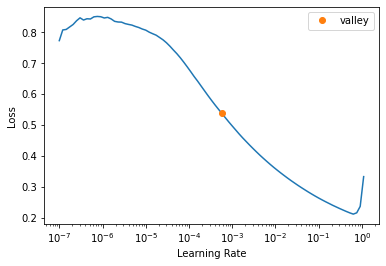

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,SMAPE,time
0,0.099961,0.144975,5.260394,00:01
1,0.050994,0.019481,1.824979,00:01
2,0.032772,0.014860,1.595939,00:01
3,0.023397,0.009778,1.251520,00:01
4,0.018173,0.009814,1.326202,00:01
5,0.015061,0.009998,1.323219,00:01
6,0.013346,0.009951,1.384135,00:01
7,0.012131,0.011800,1.456521,00:01
8,0.011263,0.008629,1.291985,00:01
9,0.010380,0.008705,1.211486,00:01


In [64]:
ypred, _ = learn.get_preds()

In [65]:
len(ypred)

3312

In [74]:
np.concatenate([ypred], axis = 0)

array([[5.429824 ],
       [6.2205276],
       [4.8937416],
       ...,
       [6.887437 ],
       [7.283358 ],
       [5.9559326]], dtype=float32)

In [70]:
ypred = np.concatenate([ypred])

In [72]:
ypred.shape

(3312, 1)

In [76]:
ypred = ypred.squeeze()
ypred.shape

(3312,)

In [77]:
SMAPE(np.exp(ypred), np.exp(validy))

3.6527197666897613

In [43]:
test_idx = combined.iloc[26298:].index

In [44]:
test_idx

Int64Index([26298, 26299, 26300, 26301, 26302, 26303, 26304, 26305, 26306,
            26307,
            ...
            32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866,
            32867],
           dtype='int64', length=6570)

In [45]:
combined_test = combined.iloc[test_idx]

In [46]:
combined_test.reset_index(drop = True, inplace = True)

In [47]:
combined_test

,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,...,Is_year_start,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,26298,Finland,KaggleMart,Kaggle Mug,-inf,in_Finland,0.967750,-0.929185,1.117330,-0.345529,...,True,1.546301e+09,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,48712
1,26299,Finland,KaggleMart,Kaggle Hat,-inf,in_Finland,0.967750,-0.929185,1.117330,0.764051,...,True,1.546301e+09,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,48712
2,26300,Finland,KaggleMart,Kaggle Sticker,-inf,in_Finland,0.967750,-0.929185,1.117330,-1.278340,...,True,1.546301e+09,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,48712
3,26301,Finland,KaggleRama,Kaggle Mug,-inf,in_Finland,-0.300273,0.358641,-0.296122,-0.345529,...,True,1.546301e+09,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,48712
4,26302,Finland,KaggleRama,Kaggle Hat,-inf,in_Finland,-0.300273,0.358641,-0.296122,0.764051,...,True,1.546301e+09,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,48712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,32863,Sweden,KaggleMart,Kaggle Hat,-inf,in_Sweden,0.967750,-0.929185,1.117330,0.764051,...,False,1.577750e+09,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
6566,32864,Sweden,KaggleMart,Kaggle Sticker,-inf,in_Sweden,0.967750,-0.929185,1.117330,-1.278340,...,False,1.577750e+09,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
6567,32865,Sweden,KaggleRama,Kaggle Mug,-inf,in_Sweden,-0.300273,0.358641,-0.296122,-0.345529,...,False,1.577750e+09,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
6568,32866,Sweden,KaggleRama,Kaggle Hat,-inf,in_Sweden,-0.300273,0.358641,-0.296122,0.764051,...,False,1.577750e+09,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687


In [48]:
to_test = TabularPandas(combined_test, procs, cat, cont, y_names = dep_var, splits = None)

In [49]:
#dls_test = to_test.dataloaders(1024)

In [50]:
dl = learn.dls.test_dl(to_test)

In [51]:
dl.xs

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
1,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
2,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
3,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
4,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6566,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6567,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6568,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180


In [52]:
dl.xs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           6570 non-null   int8   
 1   store             6570 non-null   int8   
 2   product           6570 non-null   int8   
 3   holiday           6570 non-null   int8   
 4   Is_month_end      6570 non-null   int8   
 5   Is_month_start    6570 non-null   int8   
 6   Is_quarter_end    6570 non-null   int8   
 7   Is_quarter_start  6570 non-null   int8   
 8   Is_year_end       6570 non-null   int8   
 9   Is_year_start     6570 non-null   int8   
 10  store_emb_1       6570 non-null   float64
 11  store_emb_2       6570 non-null   float64
 12  store_emb_3       6570 non-null   float64
 13  product_emb_1     6570 non-null   float64
 14  product_emb_2     6570 non-null   float64
 15  product_emb_3     6570 non-null   float64
 16  country_emb_1     6570 non-null   float64


In [139]:
learn.export("nn_21.pkl")

In [40]:
learn = load_learner("nn_21.pkl")

In [41]:
learn

In [60]:
y_, _ = learn.get_preds(dl = dls.valid)

In [62]:
y_ = np.concatenate([y_])

In [63]:
y_ = np.squeeze(y_)
y_.shape

(3312,)

In [64]:
SMAPE(np.exp(y_), np.exp(validy))

3.6527197666897613

In [65]:
dls.valid

In [67]:
dl.xs

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
1,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
2,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
3,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
4,0,0,0,0,2,0,2,0,2,0,...,-1.753177,-40.701427,-1.710817,-2.212361,1.292185,-0.290611,-1.201499,-0.772069,1.182351,-4.442199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6566,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6567,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180
6568,0,0,0,0,0,2,0,2,0,2,...,-1.720412,-40.701426,-1.743161,-3.106019,5.570680,-12.259708,-7.115289,-5.923400,1.900796,-4.442180


In [68]:
dls.valid.xs

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
22986,1,1,2,4,1,2,1,2,1,1,...,-0.010672,1.296964,0.470017,0.686033,-0.817816,0.872807,1.755415,1.101126,-1.169490,-0.618131
22987,1,1,1,4,1,2,1,2,1,1,...,-0.010672,1.296964,0.470017,0.686033,-0.817816,0.872807,1.755415,1.101126,-1.169490,-0.618131
22988,1,1,3,4,1,2,1,2,1,1,...,-0.010672,1.296964,0.470017,0.686033,-0.817816,0.872807,1.755415,1.101126,-1.169490,-0.618131
22989,1,2,2,4,1,2,1,2,1,1,...,-0.010672,1.296964,0.470017,0.686033,-0.817816,0.872807,1.755415,1.101126,-1.169490,-0.618131
22990,1,2,1,4,1,2,1,2,1,1,...,-0.010672,1.296964,0.470017,0.686033,-0.817816,0.872807,1.755415,1.101126,-1.169490,-0.618131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,3,1,1,3,2,1,2,1,2,1,...,1.724934,1.730866,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.270335
26294,3,1,3,3,2,1,2,1,2,1,...,1.724934,1.730866,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.270335
26295,3,2,2,3,2,1,2,1,2,1,...,1.724934,1.730866,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.270335
26296,3,2,1,3,2,1,2,1,2,1,...,1.724934,1.730866,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.270335


In [70]:
y_, _ = learn.get_preds(dl = dls.valid)

In [76]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(test_idx))
to_new = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [77]:
dls_new = to_new.dataloaders(1024, device = "cuda")

In [79]:
dls_new.valid.xs

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
26298,1,1,2,1,1,2,1,2,1,2,...,-1.727310,1.733237,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26299,1,1,1,1,1,2,1,2,1,2,...,-1.727310,1.733237,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26300,1,1,3,1,1,2,1,2,1,2,...,-1.727310,1.733237,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26301,1,2,2,1,1,2,1,2,1,2,...,-1.727310,1.733237,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26302,1,2,1,1,1,2,1,2,1,2,...,-1.727310,1.733237,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32863,3,1,1,3,2,1,2,1,2,1,...,1.724934,2.596299,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32864,3,1,3,3,2,1,2,1,2,1,...,1.724934,2.596299,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32865,3,2,2,3,2,1,2,1,2,1,...,1.724934,2.596299,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32866,3,2,1,3,2,1,2,1,2,1,...,1.724934,2.596299,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111


In [80]:
ytest, _ = learn.get_preds(dl = dls_new.valid)

/tmp/ipykernel_315/884952379.py:3: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(preds - targs) / denominator


In [81]:
ytest

tensor([[5.9997],
        [6.3896],
        [5.2451],
        ...,
        [6.8322],
        [7.2280],
        [5.9246]])

In [82]:
np.exp(ytest)

tensor([[ 403.3218],
        [ 595.6145],
        [ 189.6268],
        ...,
        [ 927.2502],
        [1377.4723],
        [ 374.1382]])

In [85]:
last_submission = pd.read_csv("subm/submission.csv")

In [86]:
last_submission.head()

,row_id,num_sold
0,26298,362.592982
1,26299,516.789415
2,26300,151.186708
3,26301,596.184447
4,26302,884.019225


In [88]:
previous = list(last_submission["num_sold"])

In [89]:
ytest = np.exp(ytest)
ytest = np.concatenate([ytest])
ytest = np.squeeze(ytest)
ytest.shape

(6570,)

In [90]:
ytest = list(ytest)

In [92]:
len(ytest), len(previous)

(6570, 6570)

In [96]:
final = []
for i,j in zip(ytest, previous) :
    k = (i+j) / 2
    final.append(k)

In [97]:
final[:4]

[382.9574102172851, 556.20195828125, 170.40676164794922, 671.5216057666016]

In [99]:
last_submission["num_sold"] = final

In [100]:
last_submission

,row_id,num_sold
0,26298,382.957410
1,26299,556.201958
2,26300,170.406762
3,26301,671.521606
4,26302,1009.250763
...,...,...
6565,32863,790.920792
6566,32864,228.064895
6567,32865,906.411326
6568,32866,1344.593468


In [101]:
last_submission.to_csv("subm/submission.csv", index = False)

In [102]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "idk man"

100%|████████████████████████████████████████| 156k/156k [00:03<00:00, 42.8kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022

In [105]:
final = np.ceil(final)

In [106]:
last_submission["num_sold"] = final

In [107]:
last_submission.head()

,row_id,num_sold
0,26298,383.0
1,26299,557.0
2,26300,171.0
3,26301,672.0
4,26302,1010.0


In [108]:
last_submission.to_csv("subm/submission.csv", index = False)

In [109]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "idk man"

100%|██████████████████████████████████████| 77.2k/77.2k [00:04<00:00, 16.4kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022

In [110]:
ytest, _ = learn.get_preds(dl = dls_new.valid)

/tmp/ipykernel_315/884952379.py:3: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(preds - targs) / denominator


In [111]:
ytest

tensor([[5.9997],
        [6.3896],
        [5.2451],
        ...,
        [6.8322],
        [7.2280],
        [5.9246]])

In [112]:
ytest = np.exp(ytest)
ytest = np.concatenate([ytest])
ytest = np.squeeze(ytest)
ytest.shape

(6570,)

In [113]:
ytest

array([ 403.32184,  595.6145 ,  189.62682, ...,  927.25024, 1377.4723 ,
        374.13824], dtype=float32)

In [114]:
last_submission["num_sold"] = list(ytest)

In [115]:
last_submission.head()

,row_id,num_sold
0,26298,403.321838
1,26299,595.614502
2,26300,189.626816
3,26301,746.858765
4,26302,1134.482300


In [116]:
last_submission.to_csv("subm/submission.csv", index = False)

In [117]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "idk man"

100%|████████████████████████████████████████| 101k/101k [00:04<00:00, 21.2kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022